<a href="https://colab.research.google.com/github/danaderp/SecureReqNet/blob/master/alpha_securereqnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Alpha-SecureReqNet

In [1]:
#danaderp May6'19
#Prediction For Main Issues Data Set 
#alpha-SecureReqNet

In [2]:
import csv
from tensorflow.keras.preprocessing import text
from nltk.corpus import gutenberg
from string import punctuation
from tensorflow.keras.preprocessing.sequence import skipgrams

import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt

from nltk.stem.snowball import SnowballStemmer
englishStemmer=SnowballStemmer("english")

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/thutran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
#Importing Neural Dependencies
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dot, Input, Dense, Reshape, LSTM, Conv2D, Flatten, MaxPooling1D, Dropout, MaxPooling2D
from tensorflow.keras.layers import Embedding, Multiply, Subtract
from tensorflow.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
print(tf.__version__)

2.1.0


In [5]:
#Visualize model structure
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import TSNE

Using TensorFlow backend.


In [24]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [25]:
# import sys
# sys.path.append('/content/gdrive/My Drive/Colab Notebooks/secure-req-net')

In [26]:
#! unzip /content/gdrive/My\ Drive/Colab\ Notebooks/secure-req-net/datasets/augmented_dataset/augmented_dataset.zip

In [27]:
#! cp -r issues/ /content/gdrive/My\ Drive/Colab\ Notebooks/secure-req-net/datasets/augmented_dataset/

In [6]:
import io, os, sys, types

from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

In [7]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path

    This turns "foo.bar" into "foo/bar.ipynb"
    and tries turning "Foo_Bar" into "Foo Bar" if Foo_Bar
    does not exist.
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path

In [8]:
class NotebookLoader(object):
    """Module Loader for Jupyter Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path

    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)

        print ("importing Jupyter notebook from %s" % path)

        # load the notebook object
        with io.open(path, 'r', encoding='utf-8') as f:
            nb = read(f, 4)


        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod

        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__

        try:
            for cell in nb.cells:
                if cell.cell_type == 'code':
                    # transform the input to executable Python
                    code = self.shell.input_transformer_manager.transform_cell(cell.source)
                    # run the code in themodule
                    exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [9]:
class NotebookFinder(object):
    """Module finder that locates Jupyter Notebooks"""
    def __init__(self):
        self.loaders = {}

    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return

        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)

        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [10]:
sys.meta_path.append(NotebookFinder())

In [12]:
import notebook_utils.statistics.Embeddings as Embeddings

In [13]:
ls nbpackage


ls: cannot access 'nbpackage': No such file or directory


In [14]:
from data.read_data import Dynamic_Dataset
from data.read_data import Processing_Dataset

### Loading word embeddings from previous compression

In [15]:
path = "data/augmented_dataset/" #Place here the dataset you want to process
process_unit = Processing_Dataset(path)
ground_truth = process_unit.get_ground_truth()

In [16]:
dataset = Dynamic_Dataset(ground_truth, path)
test, train = process_unit.get_test_and_training(ground_truth)
print(len(test),len(train))
print(test[0],train[0])

11612 104510
('(1,0)', 'Unspecified vulnerability in Oracle Java SE 6u95, 7u80, and 8u45; JRockit R28.3.6; and Java SE Embedded 7u75 and 8u33 allows remote attackers to affect availability via vectors related to JNDI.') ('(1,0)', 'The currently used Rails version, in the stable branch, is insecure\n\nYou should update the Gemfile.lock to hotfix this.\n\nhttp://weblog.rubyonrails.org/2014/2/18/Rails_3_2_17_4_0_3_and_4_1_0_beta2_have_been_released/')


In [21]:
#Preprocesing Corpora
# embeddings = Embeddings()
max_words = 5000 #<------- [Parameter]
pre_corpora_train = [doc for doc in train if len(doc[1])< max_words]
pre_corpora_test = [doc for doc in test if len(doc[1])< max_words]

In [22]:
print(len(pre_corpora_train),len(pre_corpora_test))

103867 11548


In [23]:
#Loading embeddings
# embed_path = '/content/gdrive/My Drive/Colab Notebooks/secure-req-net/datasets/augmented_dataset/word_embeddings-embed_size_100-epochs_100.csv'
# embeddings_dict = embeddings.get_embeddings_dict(embed_path)
# Does not work

In [24]:
# Rewrite cell above
import pandas as pd
embed_path = 'data/word_embeddings-embed_size_100-epochs_100.csv'
df = pd.read_csv(embed_path)
cols = df.columns[1:]

embeddings_dict = {}
for i in cols:
    rows = df.iloc[:, 1]
    embeddings_dict[i] = list(rows)

In [67]:
pre_corpora_train[0][1]

'The currently used Rails version, in the stable branch, is insecure\n\nYou should update the Gemfile.lock to hotfix this.\n\nhttp://weblog.rubyonrails.org/2014/2/18/Rails_3_2_17_4_0_3_and_4_1_0_beta2_have_been_released/'

In [26]:
# corpora_train = [embeddings.vectorize(doc[1], embeddings_dict) for doc in pre_corpora_train]#vectorization Inputs
# corpora_test = [embeddings.vectorize(doc[1], embeddings_dict) for doc in pre_corpora_test]#vectorization

In [176]:
corpora_train = np.array([[0,0,0,0,0,0,0,0,0,0], [0,1,0,1,0,1,0,1,0,1]], np.float)
corpora_test = np.array([[1,0,1,0,1,0,1,0,1,0], [1,1,1,1,1,1,1,1,1,1]], np.float)

In [222]:
target_train = np.array([[1, 0], [0, 1]])
target_test = np.array([[0,1], [1,0]])

In [223]:
# target_train = [[int(list(doc[0])[1]),int(list(doc[0])[3])] for doc in pre_corpora_train]#vectorization Output
# target_test = [[int(list(doc[0])[1]),int(list(doc[0])[3])]for doc in pre_corpora_test]#vectorization Output

In [225]:
max_len_sentences_train = max([len(doc) for doc in corpora_train]) #<------- [Parameter]
max_len_sentences_test = max([len(doc) for doc in corpora_test]) #<------- [Parameter]

In [226]:
max_len_sentences = max(max_len_sentences_train,max_len_sentences_test)
print("Max. Sentence # words:",max_len_sentences)

Max. Sentence # words: 10


In [227]:
min_len_sentences_train = min([len(doc) for doc in corpora_train]) #<------- [Parameter]
min_len_sentences_test = min([len(doc) for doc in corpora_test]) #<------- [Parameter]

In [228]:
min_len_sentences = max(min_len_sentences_train,min_len_sentences_test)
print("Min. Sentence # words:",min_len_sentences)

Min. Sentence # words: 10


In [229]:
embed_size = np.size(corpora_train[0][0])

### Designing Baseline Architecture

In [230]:
#BaseLine Architecture <-------
embeddigs_cols = embed_size
input_sh = (max_len_sentences,embeddigs_cols,1)
#Selecting filters? 
#https://stackoverflow.com/questions/48243360/how-to-determine-the-filter-parameter-in-the-keras-conv2d-function
#https://stats.stackexchange.com/questions/196646/what-is-the-significance-of-the-number-of-convolution-filters-in-a-convolutional

N_filters = 128 # <-------- [HyperParameter] Powers of 2 Numer of Features
K = 2 # <-------- [HyperParameter] Number of Classess

In [231]:
input_sh

(10, 1, 1)

In [232]:
gram_input = Input(shape = input_sh)
# 1st Convolutional Layer Convolutional Layer (7-gram)
conv_1_layer = Conv2D(filters=32, input_shape=input_sh, activation='relu', 
                      kernel_size=(7,embeddigs_cols), padding='valid')(gram_input)
conv_1_layer.shape

TensorShape([None, 4, 1, 32])

In [233]:
# Max Pooling 
max_1_pooling = MaxPooling2D(pool_size=((max_len_sentences-7+1),1), strides=None, padding='valid')(conv_1_layer)
max_1_pooling.shape

TensorShape([None, 1, 1, 32])

In [234]:
# Fully Connected layer
fully_connected_1_gram = Flatten()(max_1_pooling)
fully_connected_1_gram.shape

TensorShape([None, 32])

In [235]:
fully_connected_1_gram = Reshape((32, 1, 1))(fully_connected_1_gram)
fully_connected_1_gram.shape

TensorShape([None, 32, 1, 1])

In [236]:
# 2nd Convolutional Layer (5-gram)
conv_2_layer = Conv2D(filters=64, kernel_size=(5,1), activation='relu', 
                      padding='valid')(fully_connected_1_gram)
conv_2_layer.shape

TensorShape([None, 28, 1, 64])

In [237]:
max_2_pooling = MaxPooling2D(pool_size=((32-5+1),1), strides=None, padding='valid')(conv_2_layer)
max_2_pooling.shape

TensorShape([None, 1, 1, 64])

In [238]:
# Fully Connected layer
fully_connected_2_gram = Flatten()(max_2_pooling)
fully_connected_2_gram.shape

TensorShape([None, 64])

In [239]:
fully_connected_2_gram = Reshape((64, 1, 1))(fully_connected_2_gram)
fully_connected_2_gram.shape

TensorShape([None, 64, 1, 1])

In [240]:
# 3rd Convolutional Layer (3-gram)
conv_3_layer =  Conv2D(filters=128, kernel_size=(3,1), activation='relu', 
                      padding='valid')(fully_connected_2_gram)
conv_3_layer.shape

TensorShape([None, 62, 1, 128])

In [241]:
# 4th Convolutional Layer (3-gram)
conv_4_layer = Conv2D(filters=128, kernel_size=(3,1), activation='relu', 
                     padding='valid')(conv_3_layer)
conv_4_layer.shape

TensorShape([None, 60, 1, 128])

In [242]:
# 5th Convolutional Layer (3-gram)
conv_5_layer = Conv2D(filters=64, kernel_size=(3,1), activation='relu', 
                     padding='valid')(conv_4_layer)
conv_5_layer.shape

TensorShape([None, 58, 1, 64])

In [243]:
# Max Pooling
max_5_pooling = MaxPooling2D(pool_size=(58,1), strides=None, padding='valid')(conv_5_layer)
max_5_pooling.shape

TensorShape([None, 1, 1, 64])

In [244]:
# Fully Connected layer
fully_connected = Flatten()(max_5_pooling)
fully_connected.shape

TensorShape([None, 64])

In [245]:
# 1st Fully Connected Layer
deep_dense_1_layer = Dense(32, activation='relu')(fully_connected)
deep_dense_1_layer = Dropout(0.2)(deep_dense_1_layer) # <-------- [HyperParameter]
deep_dense_1_layer.shape

TensorShape([None, 32])

In [246]:
# 2nd Fully Connected Layer
deep_dense_2_layer = Dense(32, activation='relu')(deep_dense_1_layer)
deep_dense_2_layer = Dropout(0.2)(deep_dense_2_layer) # <-------- [HyperParameter]
deep_dense_2_layer.shape

TensorShape([None, 32])

In [247]:
# 3rd Fully Connected Layer
deep_dense_3_layer = Dense(16, activation='relu')(deep_dense_2_layer)
deep_dense_3_layer = Dropout(0.2)(deep_dense_3_layer) # <-------- [HyperParameter]
deep_dense_3_layer.shape

TensorShape([None, 16])

In [248]:
predictions = Dense(K, activation='softmax')(deep_dense_3_layer)
#Criticality Model
criticality_network = Model(inputs=[gram_input],outputs=[predictions]) 

In [249]:
print(criticality_network.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 10, 1, 1)]        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 4, 1, 32)          256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 1, 1, 32)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 32)                0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 32, 1, 1)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 1, 64)         384       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 1, 1, 64)          0   

In [250]:
#Seting up the Model
criticality_network.compile(optimizer='adam',loss='binary_crossentropy',
                                  metrics=['accuracy'])

### Training the criticality network

In [251]:
#Data set organization
from tempfile import mkdtemp
import os.path as path

In [252]:
#Memoization 
# file_corpora_train_x = path.join(mkdtemp(), '/content/gdrive/My Drive/Colab Notebooks/secure-req-net/alex-res-adapted-003_temp_corpora_train_x.dat') #Update per experiment
# file_corpora_test_x = path.join(mkdtemp(), '/content/gdrive/My Drive/Colab Notebooks/secure-req-net/alex-res-adapted-003_temp_corpora_test_x.dat')

In [253]:
#Memoization 
file_corpora_train_x = 'train_x.dat'
file_corpora_test_x = 'test_x.dat'

In [254]:
#Shaping
shape_train_x = (len(corpora_train),max_len_sentences,embeddigs_cols,1)
shape_test_x = (len(corpora_test),max_len_sentences,embeddigs_cols,1)

In [255]:
#Data sets
corpora_train_x = np.memmap(
        filename = file_corpora_train_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_train_x)

In [256]:
corpora_test_x = np.memmap( #Test Corpora (for future evaluation)
        filename = file_corpora_test_x, 
        dtype='float32', 
        mode='w+', 
        shape = shape_test_x)

In [257]:
target_train_y = np.array(target_train) #Train Target
target_test_y = np.array(target_test) #Test Target (for future evaluation)

In [258]:
print(corpora_train_x.shape, target_train_y.shape)

(2, 10, 1, 1) (2, 2)


In [259]:
print(corpora_test_x.shape,target_test_y.shape)

(2, 10, 1, 1) (2, 2)


In [260]:
#Reshaping Train Inputs
for doc in range(len(corpora_train)):
    #print(corpora_train[doc].shape[1])
    for words_rows in range(corpora_train[doc].shape[0]):
        embed_flatten = np.array(corpora_train[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_train_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [261]:
#Reshaping Test Inputs (for future evaluation)
for doc in range(len(corpora_test)):
    for words_rows in range(corpora_test[doc].shape[0]):
        embed_flatten = np.array(corpora_test[doc][words_rows]).flatten() #<--- Capture doc and word
        for embedding_cols in range(embed_flatten.shape[0]):
            corpora_test_x[doc,words_rows,embedding_cols,0] = embed_flatten[embedding_cols]

In [262]:
#CheckPoints
# filepath = "/content/gdrive/My Drive/Colab Notebooks/secure-req-net/best_model.hdf5"
filepath = 'best_model.hdf5'

In [263]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint(filepath, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks_list = [es,mc]

In [264]:
#Model Fitting
history = criticality_network.fit(
            x = corpora_train_x, 
            y = target_train_y,
            #batch_size=64,
            epochs=1, #5 <------ Hyperparameter
            validation_split = 0.2,
            callbacks=callbacks_list
)

Train on 1 samples, validate on 1 samples

Epoch 00001: val_accuracy improved from -inf to 1.00000, saving model to best_model.hdf5
1/1 [==============================] - 4s 4s/sample - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6894 - val_accuracy: 1.0000


In [266]:
#Saving Training History
df_history = pd.DataFrame.from_dict(history.history)
# df_history.to_csv('/content/gdrive/My Drive/Colab Notebooks/secure-req-net/history_training.csv', encoding='utf-8',index=False)
df_history.to_csv('history_training.csv', encoding='utf-8',index=False)

In [267]:
criticality_network.save(filepath)
df_history.head()

,loss,accuracy,val_loss,val_accuracy
0,0.693147,0.5,0.689391,1.0


In [ ]:
#Saving Test Data
# np.save('/content/gdrive/My Drive/Colab Notebooks/secure-req-net/corpora_test_x.npy',corpora_test_x)
# np.save('/content/gdrive/My Drive/Colab Notebooks/secure-req-net/target_test_y.npy',target_test_y)

In [268]:
#Saving Test Data
np.save('corpora_test_x.npy',corpora_test_x)
np.save('target_test_y.npy',target_test_y)

### Partial Evaluation
To make a deep evaluation, please refer to the "evaluation" notebook.

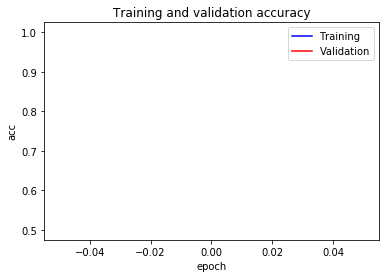

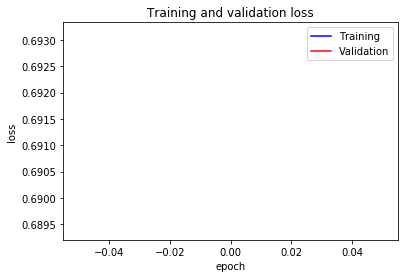

In [275]:
#Evaluation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs2 = range(len(acc))
 
plt.plot(epochs2, acc, 'b', label='Training')
plt.plot(epochs2, val_acc, 'r', label='Validation')
plt.title('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend()
 
plt.figure()
 
plt.plot(epochs2, loss, 'b', label='Training')
plt.plot(epochs2, val_loss, 'r', label='Validation')
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
 
plt.show()